Name: Namrata Bhorade

Class: BE COMPS

Batch: A

UID: 2018130004

# CEEL 82B, Data Science, 2022
# Lab 3: Data Classification


**Objective**:

(i) Apply Naive bayes classifier for given data see Naive_bayes_handout.zip file in edmodo.

(ii) Apply and compare Linear Discriminating Analysis with Naive bayes classifiers w.r.t. error, specificity and sensitivity

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import bz2 # To open zipped files
import re # regular expressions
import os
import gc

import matplotlib.pyplot as plt
import seaborn as sns

from wordcloud import WordCloud, STOPWORDS

from nltk.corpus import stopwords
import nltk
from nltk import pos_tag
from nltk import sent_tokenize, word_tokenize
from nltk.stem import WordNetLemmatizer
from string import punctuation

from sklearn.feature_extraction.text import CountVectorizer

from sklearn.preprocessing import StandardScaler, MinMaxScaler

from sklearn.naive_bayes import MultinomialNB

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, roc_auc_score, auc, classification_report

from prettytable import PrettyTable

import warnings
warnings.filterwarnings("ignore")

# Load the Dataset

In [ ]:
train_file = bz2.BZ2File('/content/drive/MyDrive/DS-Lab/Lab/Exp3/train.ft.txt.bz2')
test_file = bz2.BZ2File('/content/drive/MyDrive/DS-Lab/Lab/Exp3/test.ft.txt.bz2')

In [ ]:
train_file_lines = train_file.readlines()
test_file_lines = test_file.readlines()

In [ ]:
train_file_lines[0]

b'__label__2 Stuning even for the non-gamer: This sound track was beautiful! It paints the senery in your mind so well I would recomend it even to people who hate vid. game music! I have played the game Chrono Cross but out of all of the games I have ever played it has the best music! It backs away from crude keyboarding and takes a fresher step with grate guitars and soulful orchestras. It would impress anyone who cares to listen! ^_^\n'

In [ ]:
# clean the older variables
del train_file, test_file
gc.collect()

11

# Data Preprocessing and Visualization

## Converting string from raw binary string to string that can be parsed.

In [ ]:
train_file_lines = [x.decode('utf-8') for x in train_file_lines]
test_file_lines = [x.decode('utf-8') for x in test_file_lines]

In [ ]:
train_file_lines[0]

'__label__2 Stuning even for the non-gamer: This sound track was beautiful! It paints the senery in your mind so well I would recomend it even to people who hate vid. game music! I have played the game Chrono Cross but out of all of the games I have ever played it has the best music! It backs away from crude keyboarding and takes a fresher step with grate guitars and soulful orchestras. It would impress anyone who cares to listen! ^_^\n'

In [ ]:
print(type(train_file_lines), type(test_file_lines), "\n")

print("Train Data Volume:", len(train_file_lines), "\n")
print("Test Data Volume:", len(test_file_lines), "\n\n")

<class 'list'> <class 'list'> 

Train Data Volume: 3600000 

Test Data Volume: 400000 




## Extracting Labels from the data

0 -> __label__1 -> 1/2 star rating

1 -> __label__2 -> 4/5 star rating

In [ ]:
train_labels = [0 if x.split(' ')[0] == '__label__1' else 1 for x in train_file_lines]
test_labels = [0 if x.split(' ')[0] == '__label__1' else 1 for x in test_file_lines]

In [ ]:
train_labels[0]

1

## Distribution of Labels in Train and Test Set

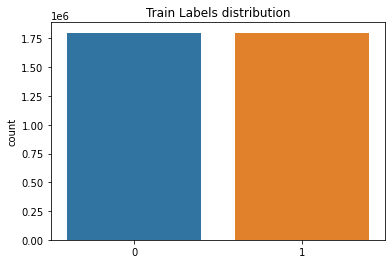

In [ ]:
sns.countplot(train_labels)
plt.title('Train Labels distribution')
plt.show()

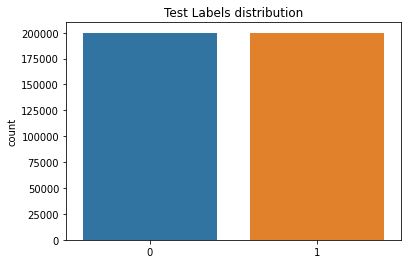

In [ ]:
sns.countplot(test_labels)
plt.title('Test Labels distribution')
plt.show()

We can see that there are equal number of entries for both the classes in both train and test dataset.

## Cleaning new line character and extracting review

In [ ]:
train_sentences = [x.split(' ', 1)[1][:-1] for x in train_file_lines]
test_sentences = [x.split(' ', 1)[1][:-1] for x in test_file_lines]

In [ ]:
train_sentences[0]

'Stuning even for the non-gamer: This sound track was beautiful! It paints the senery in your mind so well I would recomend it even to people who hate vid. game music! I have played the game Chrono Cross but out of all of the games I have ever played it has the best music! It backs away from crude keyboarding and takes a fresher step with grate guitars and soulful orchestras. It would impress anyone who cares to listen! ^_^'

## Number of Words in Reviews and its Distribution

In [ ]:
# counting number of words in each review
train_sentences_size = list(map(lambda x: len(x.split()), train_sentences))

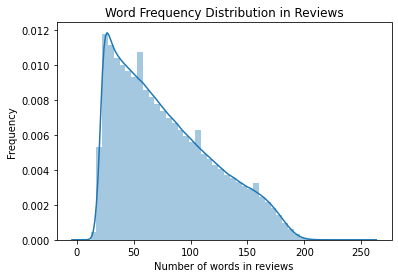

In [ ]:
sns.distplot(train_sentences_size)
plt.xlabel("Number of words in reviews")
plt.ylabel("Frequency")
plt.title("Word Frequency Distribution in Reviews")
plt.show()

## Cleaning URLs

In [ ]:
for i in range(len(train_sentences)):
    if 'www.' in train_sentences[i] or 'http:' in train_sentences[i] or 'https:' in train_sentences[i] or '.com' in train_sentences[i]:
        train_sentences[i] = re.sub(r"([^ ]+(?<=\.[a-z]{3}))", "<url>", train_sentences[i])

In [ ]:
for i in range(len(test_sentences)):
    if 'www.' in test_sentences[i] or 'http:' in test_sentences[i] or 'https:' in test_sentences[i] or '.com' in test_sentences[i]:
        test_sentences[i] = re.sub(r"([^ ]+(?<=\.[a-z]{3}))", "<url>", test_sentences[i])

In [ ]:
list(filter(lambda x: '<url>' in x, train_sentences))[0]

"Bad Deal!!: I ordered this DVD and received a substitute I never received the DVD I ordered from Importcds (the Vendor). I contacted them and did not recieve any feedback. I can't rate a DVD I have never seen. I didn't bother to send it back because it would have cost me more that I orginally paid for it. In the future I will watch for the name of the person and/or persons I am buying from. I thought they were a good company. I understand a simple mistake but, to not get a response at all is not good businees sense. I spend hundreds of dollars a month on <url> building my DVD collection. I guess I will be more careful in the future."

We can see here that the actual URL is substituted by <'url'>

In [ ]:
del train_file_lines, test_file_lines
gc.collect()

10389

## Tokenization and Lemmatization

In [ ]:
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [ ]:
wnl = WordNetLemmatizer()

In [ ]:
# Converts Penn Treebank tags to WordNet.
def penn2morphy(penntag):
    morphy_tag = {'NN':'n', 'JJ':'a',
                  'VB':'v', 'RB':'r'}
    try:
        return morphy_tag[penntag[:2]]
    except:
        return 'n' 

In [ ]:
def lemmatize_sentence(text): 
    # Text input is string, returns lowercased strings.
    return [wnl.lemmatize(word.lower(), pos=penn2morphy(tag)) 
            for word, tag in pos_tag(word_tokenize(text))]

In [ ]:
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
lemmatize_sentence('I am reading a book')

['i', 'be', 'read', 'a', 'book']

## Stopwords and Punctuation

The stopword-json is given at the url given below and it has stopwrds in 50 languages
https://github.com/6/stopwords-json

In [ ]:
# Stopwords from stopwords-json
stopwords_json = {"en":["a","a's","able","about","above","according","accordingly","across","actually","after","afterwards","again","against","ain't","all","allow","allows","almost","alone","along","already","also","although","always","am","among","amongst","an","and","another","any","anybody","anyhow","anyone","anything","anyway","anyways","anywhere","apart","appear","appreciate","appropriate","are","aren't","around","as","aside","ask","asking","associated","at","available","away","awfully","b","be","became","because","become","becomes","becoming","been","before","beforehand","behind","being","believe","below","beside","besides","best","better","between","beyond","both","brief","but","by","c","c'mon","c's","came","can","can't","cannot","cant","cause","causes","certain","certainly","changes","clearly","co","com","come","comes","concerning","consequently","consider","considering","contain","containing","contains","corresponding","could","couldn't","course","currently","d","definitely","described","despite","did","didn't","different","do","does","doesn't","doing","don't","done","down","downwards","during","e","each","edu","eg","eight","either","else","elsewhere","enough","entirely","especially","et","etc","even","ever","every","everybody","everyone","everything","everywhere","ex","exactly","example","except","f","far","few","fifth","first","five","followed","following","follows","for","former","formerly","forth","four","from","further","furthermore","g","get","gets","getting","given","gives","go","goes","going","gone","got","gotten","greetings","h","had","hadn't","happens","hardly","has","hasn't","have","haven't","having","he","he's","hello","help","hence","her","here","here's","hereafter","hereby","herein","hereupon","hers","herself","hi","him","himself","his","hither","hopefully","how","howbeit","however","i","i'd","i'll","i'm","i've","ie","if","ignored","immediate","in","inasmuch","inc","indeed","indicate","indicated","indicates","inner","insofar","instead","into","inward","is","isn't","it","it'd","it'll","it's","its","itself","j","just","k","keep","keeps","kept","know","known","knows","l","last","lately","later","latter","latterly","least","less","lest","let","let's","like","liked","likely","little","look","looking","looks","ltd","m","mainly","many","may","maybe","me","mean","meanwhile","merely","might","more","moreover","most","mostly","much","must","my","myself","n","name","namely","nd","near","nearly","necessary","need","needs","neither","never","nevertheless","new","next","nine","no","nobody","non","none","noone","nor","normally","not","nothing","novel","now","nowhere","o","obviously","of","off","often","oh","ok","okay","old","on","once","one","ones","only","onto","or","other","others","otherwise","ought","our","ours","ourselves","out","outside","over","overall","own","p","particular","particularly","per","perhaps","placed","please","plus","possible","presumably","probably","provides","q","que","quite","qv","r","rather","rd","re","really","reasonably","regarding","regardless","regards","relatively","respectively","right","s","said","same","saw","say","saying","says","second","secondly","see","seeing","seem","seemed","seeming","seems","seen","self","selves","sensible","sent","serious","seriously","seven","several","shall","she","should","shouldn't","since","six","so","some","somebody","somehow","someone","something","sometime","sometimes","somewhat","somewhere","soon","sorry","specified","specify","specifying","still","sub","such","sup","sure","t","t's","take","taken","tell","tends","th","than","thank","thanks","thanx","that","that's","thats","the","their","theirs","them","themselves","then","thence","there","there's","thereafter","thereby","therefore","therein","theres","thereupon","these","they","they'd","they'll","they're","they've","think","third","this","thorough","thoroughly","those","though","three","through","throughout","thru","thus","to","together","too","took","toward","towards","tried","tries","truly","try","trying","twice","two","u","un","under","unfortunately","unless","unlikely","until","unto","up","upon","us","use","used","useful","uses","using","usually","uucp","v","value","various","very","via","viz","vs","w","want","wants","was","wasn't","way","we","we'd","we'll","we're","we've","welcome","well","went","were","weren't","what","what's","whatever","when","whence","whenever","where","where's","whereafter","whereas","whereby","wherein","whereupon","wherever","whether","which","while","whither","who","who's","whoever","whole","whom","whose","why","will","willing","wish","with","within","without","won't","wonder","would","wouldn't","x","y","yes","yet","you","you'd","you'll","you're","you've","your","yours","yourself","yourselves","z","zero"]}
stopwords_json_en = set(stopwords_json['en'])

In [ ]:
# Stopwords from nltk
stopwords_nltk_en = set(stopwords.words('english'))

In [ ]:
# Punctuations from string library of python
stopwords_punct = set(punctuation)

In [ ]:
# Combining all stopwords and punctuations
stoplist_combined = set.union(stopwords_nltk_en, stopwords_punct)

In [ ]:
def preprocess_text(text):
    return [word for word in lemmatize_sentence(text) if word not in stoplist_combined and not word.isdigit()]

In [ ]:
train_sentences[0]

'Stuning even for the non-gamer: This sound track was beautiful! It paints the senery in your mind so well I would recomend it even to people who hate vid. game music! I have played the game Chrono Cross but out of all of the games I have ever played it has the best music! It backs away from crude keyboarding and takes a fresher step with grate guitars and soulful orchestras. It would impress anyone who cares to listen! ^_^'

In [ ]:
preprocess_text(train_sentences[0])

['stun',
 'even',
 'non-gamer',
 'sound',
 'track',
 'beautiful',
 'paint',
 'senery',
 'mind',
 'well',
 'would',
 'recomend',
 'even',
 'people',
 'hate',
 'vid',
 'game',
 'music',
 'play',
 'game',
 'chrono',
 'cross',
 'game',
 'ever',
 'play',
 'best',
 'music',
 'back',
 'away',
 'crude',
 'keyboarding',
 'take',
 'fresh',
 'step',
 'grate',
 'guitar',
 'soulful',
 'orchestra',
 'would',
 'impress',
 'anyone',
 'care',
 'listen',
 '^_^']

## Vectorization

In [ ]:
count_vect = CountVectorizer(analyzer=preprocess_text, max_features=6000)

In [ ]:
train_set = count_vect.fit_transform(train_sentences[:10000])

In [ ]:
train_set

<10000x6000 sparse matrix of type '<class 'numpy.int64'>'
	with 315070 stored elements in Compressed Sparse Row format>

In [ ]:
train_set.toarray().shape

(10000, 6000)

In [ ]:
count_vect.get_feature_names_out()

array(["''", "'d", "'em", ..., 'zombie', 'zone', 'zoom'], dtype=object)

In [ ]:
# calculate sparsity
def calculateSparsity(matrix):
    return 1.0 - (np.count_nonzero(matrix))/ float(matrix.size)

In [ ]:
sparsity_original_train = calculateSparsity(train_set.todense())
print("Sparsity of Original Train Set: ", round(sparsity_original_train, 4))

Sparsity of Original Train Set:  0.9947


In [ ]:
test_set = count_vect.transform(test_sentences[:1000])

In [ ]:
sparsity_original_test = calculateSparsity(test_set.todense())
print("Sparsity of Original Test Set: ", round(sparsity_original_test,4))

Sparsity of Original Test Set:  0.9948


In [ ]:
test_set.toarray().shape

(1000, 6000)

## Most Frequent Words

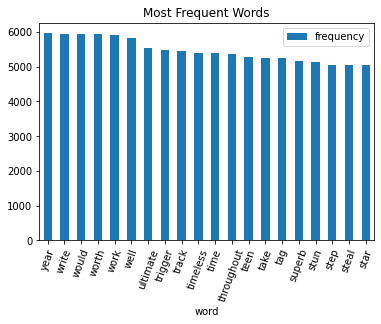

In [ ]:
most_freq_words = pd.DataFrame(count_vect.vocabulary_.items(), columns=['word', 'frequency'])[:100].sort_values(ascending=False, by = "frequency")[:20]
most_freq_words.plot.bar(x="word", y="frequency", rot=70, title="Most Frequent Words")
plt.show()

# Model and Evaluation

# Naive Bayes

## Build the Model

In [ ]:
nb_model = MultinomialNB()
nb_model.fit(train_set, train_labels[:10000])

MultinomialNB()

## Prediction

In [ ]:
pred_labels = nb_model.predict(test_set)

## Accuracy

In [ ]:
accuracy_naive_bayes = accuracy_score(test_labels[:1000], pred_labels) * 100
print('Accuracy (Naive Bayes): ', round(accuracy_naive_bayes, 4), "%")

Accuracy (Naive Bayes):  82.3 %


In [ ]:
gc.collect()

4702

## Confusion Matrix

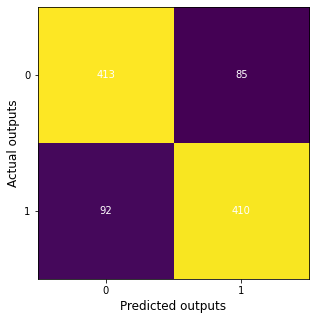

In [ ]:
cm = confusion_matrix(test_labels[:1000], pred_labels)

fig, ax = plt.subplots(figsize=(5, 5))
ax.imshow(cm)
ax.grid(False)
ax.set_xlabel('Predicted outputs', fontsize=12, color='black')
ax.set_ylabel('Actual outputs', fontsize=12, color='black')
ax.xaxis.set(ticks=range(2))
ax.yaxis.set(ticks=range(2))
for i in range(2):
    for j in range(2):
        ax.text(j, i, cm[i, j], ha='center', va='center', color='white')
plt.show()

## Specificity

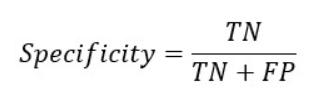

In [ ]:
specificity_naive_bayes = cm[0,0]/(cm[0,0]+cm[0,1]) * 100
print('Specificity (Naive Bayes): ', round(specificity_naive_bayes, 4), "%")

Specificity (Naive Bayes):  82.9317 %


## Sensitivity

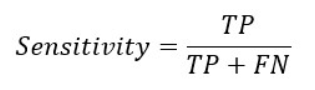

In [ ]:
sensitivity_naive_bayes = cm[1,1]/(cm[1,0]+cm[1,1]) * 100
print('Sensitivity (Naive Bayes): ', round(sensitivity_naive_bayes, 4), "%")

Sensitivity (Naive Bayes):  81.6733 %


## Classification Report

In [ ]:
print(classification_report(test_labels[:1000], pred_labels))

              precision    recall  f1-score   support

           0       0.82      0.83      0.82       498
           1       0.83      0.82      0.82       502

    accuracy                           0.82      1000
   macro avg       0.82      0.82      0.82      1000
weighted avg       0.82      0.82      0.82      1000



## ROC Curve and AUC

In [ ]:
y_prob = nb_model.predict_proba(test_set)

y_prob = y_prob[:, 1]

n_classes = len(nb_model.classes_)

fpr, tpr,_ = roc_curve(test_labels[:1000], y_prob)
roc_auc = auc(fpr, tpr)

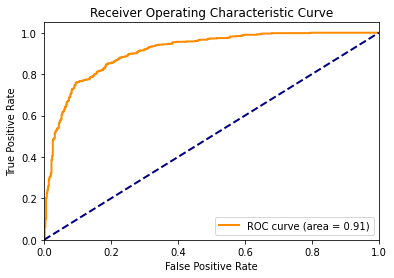

In [ ]:
lw = 2
plt.plot(
    fpr,
    tpr,
    color="darkorange",
    lw=lw,
    label="ROC curve (area = %0.2f)" % roc_auc,
)
plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic Curve")
plt.legend(loc="lower right")
plt.show()

# LDA

## Build the Model

In [ ]:
lda_model = LinearDiscriminantAnalysis()
lda_model.fit(train_set.todense(), train_labels[:10000])

LinearDiscriminantAnalysis()

## Prediction

In [ ]:
lda_pred_labels = lda_model.predict(test_set)

## Accuracy

In [ ]:
accuracy_lda = accuracy_score(test_labels[:1000], lda_pred_labels ) * 100
print('Accuracy (LDA): ', round(accuracy_lda, 4), "%")

Accuracy (LDA):  73.0 %


## Confusion Matrix

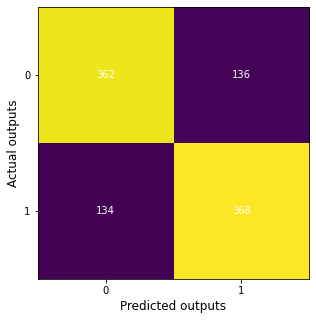

In [ ]:
cm = confusion_matrix(test_labels[:1000], lda_pred_labels)

fig, ax = plt.subplots(figsize=(5, 5))
ax.imshow(cm)
ax.grid(False)
ax.set_xlabel('Predicted outputs', fontsize=12, color='black')
ax.set_ylabel('Actual outputs', fontsize=12, color='black')
ax.xaxis.set(ticks=range(2))
ax.yaxis.set(ticks=range(2))
for i in range(2):
    for j in range(2):
        ax.text(j, i, cm[i, j], ha='center', va='center', color='white')
plt.show()

## Specificity

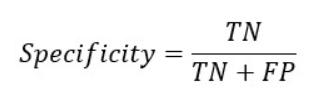

In [ ]:
specificity_lda = cm[0,0]/(cm[0,0]+cm[0,1]) * 100
print('Specificity (LDA): ', round(specificity_lda, 4), "%")

Specificity (LDA):  72.6908 %


## Sensitivity

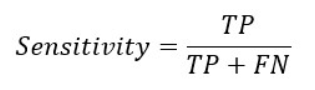

In [ ]:
sensitivity_lda = cm[1,1]/(cm[1,0]+cm[1,1]) * 100
print('Sensitivity (LDA): ', round(sensitivity_lda, 4), "%")

Sensitivity (LDA):  73.3068 %


## Classification Report

In [ ]:
print(classification_report(test_labels[:1000], lda_pred_labels))

              precision    recall  f1-score   support

           0       0.73      0.73      0.73       498
           1       0.73      0.73      0.73       502

    accuracy                           0.73      1000
   macro avg       0.73      0.73      0.73      1000
weighted avg       0.73      0.73      0.73      1000



## ROC Curve and AUC

---



In [ ]:
y_prob = lda_model.predict_proba(test_set)

y_prob = y_prob[:, 1]

n_classes = len(lda_model.classes_)

fpr, tpr,_ = roc_curve(test_labels[:1000], y_prob)
roc_auc = auc(fpr, tpr)

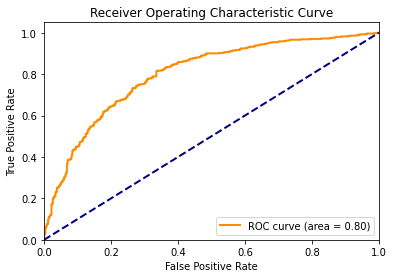

In [ ]:
lw = 2
plt.plot(
    fpr,
    tpr,
    color="darkorange",
    lw=lw,
    label="ROC curve (area = %0.2f)" % roc_auc,
)
plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic Curve")
plt.legend(loc="lower right")
plt.show()

# Dimensionality Reduction

In [ ]:
count_vect_reduced = CountVectorizer(analyzer=preprocess_text, max_features=2000)

In [ ]:
train_set_reduced = count_vect_reduced.fit_transform(train_sentences[:10000])

In [ ]:
train_set_reduced

<10000x2000 sparse matrix of type '<class 'numpy.int64'>'
	with 273906 stored elements in Compressed Sparse Row format>

In [ ]:
train_set_reduced.toarray().shape

(10000, 2000)

In [ ]:
count_vect_reduced.get_feature_names_out()

array(["''", "'d", "'ll", ..., 'yr', 'zen', 'zero'], dtype=object)

In [ ]:
sparsity_reduced_train = calculateSparsity(train_set_reduced.todense())
print("Sparsity of Lower Dimensional Train Set: ", round(sparsity_reduced_train,4))

Sparsity of Lower Dimensional Train Set:  0.9863


In [ ]:
test_set_reduced = count_vect_reduced.transform(test_sentences[:1000])

In [ ]:
sparsity_reduced_test = calculateSparsity(test_set_reduced.todense())
print("Sparsity of Lower Dimensional Test Set: ", round(sparsity_reduced_test,4))

Sparsity of Lower Dimensional Test Set:  0.9864


In [ ]:
test_set_reduced.toarray().shape

(1000, 2000)

# Naive Bayes

## Build the Model

In [ ]:
nb_model_reduced = MultinomialNB()
nb_model_reduced.fit(train_set_reduced, train_labels[:10000])

MultinomialNB()

## Prediction

In [ ]:
pred_labels_nb_reduced = nb_model_reduced.predict(test_set_reduced)

## Accuracy

In [ ]:
accuracy_naive_bayes_reduced = accuracy_score(test_labels[:1000], pred_labels_nb_reduced ) * 100
print('Accuracy (Naive Bayes): ', round(accuracy_naive_bayes_reduced, 4), "%")

Accuracy (Naive Bayes):  82.7 %


In [ ]:
gc.collect()

7346

## Confusion Matrix

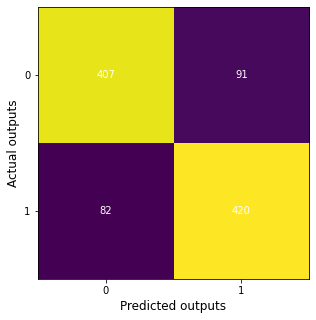

In [ ]:
cm = confusion_matrix(test_labels[:1000], pred_labels_nb_reduced)

fig, ax = plt.subplots(figsize=(5, 5))
ax.imshow(cm)
ax.grid(False)
ax.set_xlabel('Predicted outputs', fontsize=12, color='black')
ax.set_ylabel('Actual outputs', fontsize=12, color='black')
ax.xaxis.set(ticks=range(2))
ax.yaxis.set(ticks=range(2))
for i in range(2):
    for j in range(2):
        ax.text(j, i, cm[i, j], ha='center', va='center', color='white')
plt.show()

## Specificity

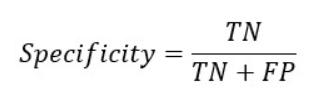

In [ ]:
specificity_naive_bayes_reduced = cm[0,0]/(cm[0,0]+cm[0,1]) * 100
print('Specificity (Naive Bayes - Lower Dimension): ', round(specificity_naive_bayes_reduced, 4), "%")

Specificity (Naive Bayes - Lower Dimension):  81.7269 %


## Sensitivity

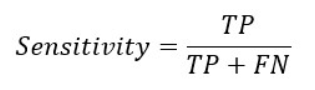

In [ ]:
sensitivity_naive_bayes_reduced = cm[1,1]/(cm[1,0]+cm[1,1]) * 100
print('Sensitivity (Naive Bayes - Lower Dimension): ', round(sensitivity_naive_bayes_reduced, 4), "%")

Sensitivity (Naive Bayes - Lower Dimension):  83.6653 %


## Classification Report

In [ ]:
print(classification_report(test_labels[:1000], pred_labels_nb_reduced))

              precision    recall  f1-score   support

           0       0.83      0.82      0.82       498
           1       0.82      0.84      0.83       502

    accuracy                           0.83      1000
   macro avg       0.83      0.83      0.83      1000
weighted avg       0.83      0.83      0.83      1000



## ROC Curve and AUC

In [ ]:
y_prob = nb_model_reduced.predict_proba(test_set_reduced)

y_prob = y_prob[:, 1]

n_classes = len(nb_model_reduced.classes_)

fpr, tpr,_ = roc_curve(test_labels[:1000], y_prob)
roc_auc = auc(fpr, tpr)

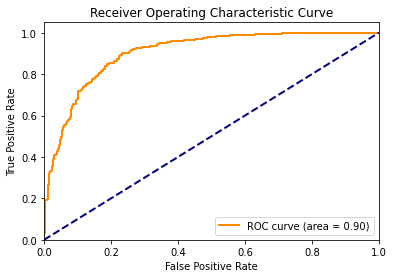

In [ ]:
lw = 2
plt.plot(
    fpr,
    tpr,
    color="darkorange",
    lw=lw,
    label="ROC curve (area = %0.2f)" % roc_auc,
)
plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic Curve")
plt.legend(loc="lower right")
plt.show()

# LDA

## Build the Model

In [ ]:
lda_model_reduced = LinearDiscriminantAnalysis()
lda_model_reduced.fit(train_set_reduced.todense(), train_labels[:10000])

LinearDiscriminantAnalysis()

## Prediction

In [ ]:
reduced_lda_pred_labels = lda_model_reduced.predict(test_set_reduced.todense())

## Accuracy

In [ ]:
accuracy_lda_reduced = accuracy_score(test_labels[:1000], reduced_lda_pred_labels ) * 100
print('Accuracy (LDA): ', round(accuracy_lda_reduced, 4), "%")

Accuracy (LDA):  83.0 %


## Confusion Matrix

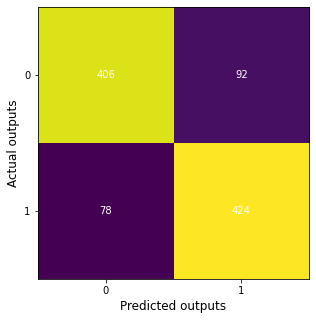

In [ ]:
cm = confusion_matrix(test_labels[:1000], reduced_lda_pred_labels)

fig, ax = plt.subplots(figsize=(5, 5))
ax.imshow(cm)
ax.grid(False)
ax.set_xlabel('Predicted outputs', fontsize=12, color='black')
ax.set_ylabel('Actual outputs', fontsize=12, color='black')
ax.xaxis.set(ticks=range(2))
ax.yaxis.set(ticks=range(2))
for i in range(2):
    for j in range(2):
        ax.text(j, i, cm[i, j], ha='center', va='center', color='white')
plt.show()

## Specificity

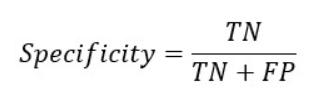

In [ ]:
specificity_lda_reduced = cm[0,0]/(cm[0,0]+cm[0,1]) * 100
print('Specificity (LDA - Lower Dimension): ', round(specificity_lda_reduced, 4), "%")

Specificity (LDA - Lower Dimension):  81.5261 %


## Sensitivity

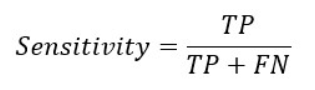

In [ ]:
sensitivity_lda_reduced = cm[1,1]/(cm[1,0]+cm[1,1]) * 100
print('Sensitivity (Naive Bayes - Lower Dimension): ', round(sensitivity_lda_reduced, 4), "%")

Sensitivity (Naive Bayes - Lower Dimension):  84.4622 %


## Classification Report

In [ ]:
print(classification_report(test_labels[:1000], reduced_lda_pred_labels))

              precision    recall  f1-score   support

           0       0.84      0.82      0.83       498
           1       0.82      0.84      0.83       502

    accuracy                           0.83      1000
   macro avg       0.83      0.83      0.83      1000
weighted avg       0.83      0.83      0.83      1000



## ROC Curve and AUC

In [ ]:
y_prob = lda_model_reduced.predict_proba(test_set_reduced.todense())

y_prob = y_prob[:, 1]

n_classes = len(lda_model_reduced.classes_)

fpr, tpr,_ = roc_curve(test_labels[:1000], y_prob)
roc_auc = auc(fpr, tpr)

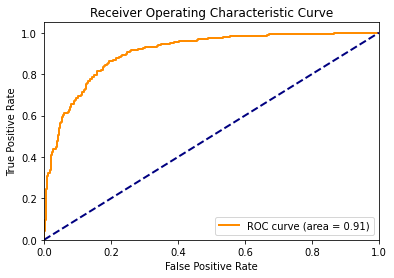

In [ ]:
lw = 2
plt.plot(
    fpr,
    tpr,
    color="darkorange",
    lw=lw,
    label="ROC curve (area = %0.2f)" % roc_auc,
)
plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic Curve")
plt.legend(loc="lower right")
plt.show()

# Comparison of Sparsity of Matrix

In [ ]:
sparsity_table = PrettyTable(['Set', 'Original Matrix', 'Lower Dimension Matrix'])
sparsity_table.add_row(['Train Set', round(sparsity_original_train,4), round(sparsity_reduced_train, 4)])
sparsity_table.add_row(['Test Set', round(sparsity_original_test,4), round(sparsity_reduced_test,4)])
print(sparsity_table)

+-----------+-----------------+------------------------+
|    Set    | Original Matrix | Lower Dimension Matrix |
+-----------+-----------------+------------------------+
| Train Set |      0.9947     |         0.9863         |
|  Test Set |      0.9948     |         0.9864         |
+-----------+-----------------+------------------------+


# Comparison of Accuracy, Specificity and Sensitivity

In [ ]:
results_table = PrettyTable(['Metric', 'Naive Bayes (Original)', 'Naive Bayes (Lower Dimension)', 'LDA (Original)', 'LDA (Lower Dimension)'])

results_table.add_row(['Accuracy', round(accuracy_naive_bayes, 4), round(accuracy_naive_bayes_reduced, 4), round(accuracy_lda, 4), round(accuracy_lda_reduced, 4)])
results_table.add_row(['Specificity', round(specificity_naive_bayes, 4), round(specificity_naive_bayes_reduced, 4), round(specificity_lda, 4), round(specificity_lda_reduced, 4)])
results_table.add_row(['Sensitivity', round(sensitivity_naive_bayes, 4), round(sensitivity_naive_bayes_reduced, 4), round(sensitivity_lda, 4), round(sensitivity_lda_reduced, 4)])
print(results_table)

+-------------+------------------------+-------------------------------+----------------+-----------------------+
|    Metric   | Naive Bayes (Original) | Naive Bayes (Lower Dimension) | LDA (Original) | LDA (Lower Dimension) |
+-------------+------------------------+-------------------------------+----------------+-----------------------+
|   Accuracy  |          82.3          |              82.7             |      73.0      |          83.0         |
| Specificity |        82.9317         |            81.7269            |    72.6908     |        81.5261        |
| Sensitivity |        81.6733         |            83.6653            |    73.3068     |        84.4622        |
+-------------+------------------------+-------------------------------+----------------+-----------------------+


# Conclusion

1. In this experiment, I learned about Naive Bayes Classifier and its various applications. I understood the concepts related to Naive Bayes such as prior probability, posterior probability, etc.
2. I considered Amazon Reviews Corpus for this experiment. I performed preprocessing operations such as cleaning, tokenization, lemmatization and vectorized it into categorical dataset.
3. The Naive Bayes model outperformed LDA with accuracy of 82.3 %. The accuracy of LDA came out to be 73.0 %.
4. After that dimensions of the matrix were redueced and increase in the accuracy was observed.(Naive Bayes - 82.7 % and LDA - 83.0 % )
5. The sparsity of the matrix was reduced after reducing the dimensions of the matrix.
6. The comparison of LDA and Naive Bayes based on various metrics such as Specificity and Sensitivity was performed. The values for this metrics were observed to be increased after reducing the dimensions.